# Student Performance from Game Play Using TensorFlow Decision Forests

## Import the Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import f1_score

## Load the Dataset

In [2]:
# Reference: https://www.kaggle.com/competitions/predict-student-performance-from-game-play/discussion/384359
dtypes={
    'elapsed_time':np.int32,
    'event_name':'category',
    'name':'category',
    'level':np.uint8,
    
    'room_coor_x':np.float32,
    'room_coor_y':np.float32,
    'screen_coor_x':np.float32,
    'screen_coor_y':np.float32,
    
    'hover_duration':np.float32,
    
    'text':'category',
    'fqid':'category',
    'room_fqid':'category',
    'text_fqid':'category',

    'fullscreen': np.int32,
    'hq': np.int32,
    'music': np.int32,

    'level_group':'category'}

dataset_df = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv', dtype=dtypes)

In [3]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26296946 entries, 0 to 26296945
Data columns (total 20 columns):
 #   Column          Dtype   
---  ------          -----   
 0   session_id      int64   
 1   index           int64   
 2   elapsed_time    int32   
 3   event_name      category
 4   name            category
 5   level           uint8   
 6   page            float64 
 7   room_coor_x     float32 
 8   room_coor_y     float32 
 9   screen_coor_x   float32 
 10  screen_coor_y   float32 
 11  hover_duration  float32 
 12  text            category
 13  fqid            category
 14  room_fqid       category
 15  text_fqid       category
 16  fullscreen      int32   
 17  hq              int32   
 18  music           int32   
 19  level_group     category
dtypes: category(7), float32(5), float64(1), int32(4), int64(2), uint8(1)
memory usage: 1.7 GB


## Load the labels

In [4]:
labels = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')

In [5]:
labels['session'] = labels.session_id.apply(lambda x: int(x.split('_')[0]) )
labels['q'] = labels.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )

# Prepare the dataset

In [6]:
CATEGORICAL = ['event_name', 'name', 'fqid', 'room_fqid', 'text_fqid']
NUMERICAL = ['page', 'location_x_diff', 'location_y_diff','hover_duration', 'elapsed_time']
OPTIONAL = ['music', 'fullscreen', 'hq']

# Lots..
NAMES = dataset_df['name'].unique()
EVENTS = dataset_df['event_name'].unique()

TEXT_LISTS = dataset_df['text'].unique()
FQID_LISTS = dataset_df['fqid'].unique()

In [7]:
# df.fillna(df.mean()), df.where(pd.notnull(df), df.mean(), axis='columns')
def feature_engineer(dataset_df):
    dataset_df['elapsed_time_diff'] = (
        (dataset_df['elapsed_time'] - dataset_df['elapsed_time'].shift(1))
        .fillna(0)
        .clip(lower=0, upper=1e9)
    )
    dataset_df['location_x_diff'] = (
        (dataset_df['room_coor_x'] - dataset_df['room_coor_x'].shift(1))
        .abs()
    )
    dataset_df['location_y_diff'] = (
        (dataset_df['room_coor_y'] - dataset_df['room_coor_y'].shift(1))
        .abs()
    )
    
    dfs = []
    
    # NUMERICAL
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('mean')
        tmp.name = tmp.name + '_mean'
        dfs.append(tmp)
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('sum')
        tmp.name = tmp.name + '_sum'
        dfs.append(tmp)
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('max')
        tmp.name = tmp.name + '_max'
        dfs.append(tmp)
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('min')
        tmp.name = tmp.name + '_min'
        dfs.append(tmp)
    
    # EVNETS
    for c in EVENTS: 
        dataset_df[c] = (dataset_df.event_name == c).astype('int8')
    for c in EVENTS: 
        tmp = dataset_df[dataset_df[c] == 1].groupby(['session_id', 'level_group'])[c].sum()
        tmp.name = c + '_count'
        dfs.append(tmp)
        
    for c in EVENTS:
        tmp = dataset_df[dataset_df[c] == 1].groupby(['session_id', 'level_group'])['elapsed_time_diff'].agg('mean')
        tmp.name = c + '_time_average'
        dfs.append(tmp)
        
        
    #OPTIONALS
    for c in OPTIONAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('mean')
        tmp.name = tmp.name + '_mean'
        dfs.append(tmp)
    for c in OPTIONAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('sum')
        tmp.name = tmp.name + '_sum'
        dfs.append(tmp)
    for c in OPTIONAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('min')
        tmp.name = tmp.name + '_min'
        dfs.append(tmp)
    for c in OPTIONAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('max')
        tmp.name = tmp.name + '_max'
        dfs.append(tmp)   
        
    dataset_df = pd.concat(dfs,axis=1)
    dataset_df = dataset_df.fillna(-1)
    dataset_df = dataset_df.reset_index()
    dataset_df = dataset_df.set_index('session_id')
    return dataset_df

In [8]:
dataset_df = feature_engineer(dataset_df)

In [9]:
missing_counts = dataset_df.isna().sum()
print(missing_counts)

level_group                        0
page_mean                          0
location_x_diff_mean               0
location_y_diff_mean               0
hover_duration_mean                0
elapsed_time_mean                  0
page_std                           0
location_x_diff_std                0
location_y_diff_std                0
hover_duration_std                 0
elapsed_time_std                   0
page_sum                           0
location_x_diff_sum                0
location_y_diff_sum                0
hover_duration_sum                 0
elapsed_time_sum                   0
page_max                           0
location_x_diff_max                0
location_y_diff_max                0
hover_duration_max                 0
elapsed_time_max                   0
page_min                           0
location_x_diff_min                0
location_y_diff_min                0
hover_duration_min                 0
elapsed_time_min                   0
cutscene_click_count               0
p

In [10]:
# pd.set_option('display.max_columns', None)
# dataset_df.head()

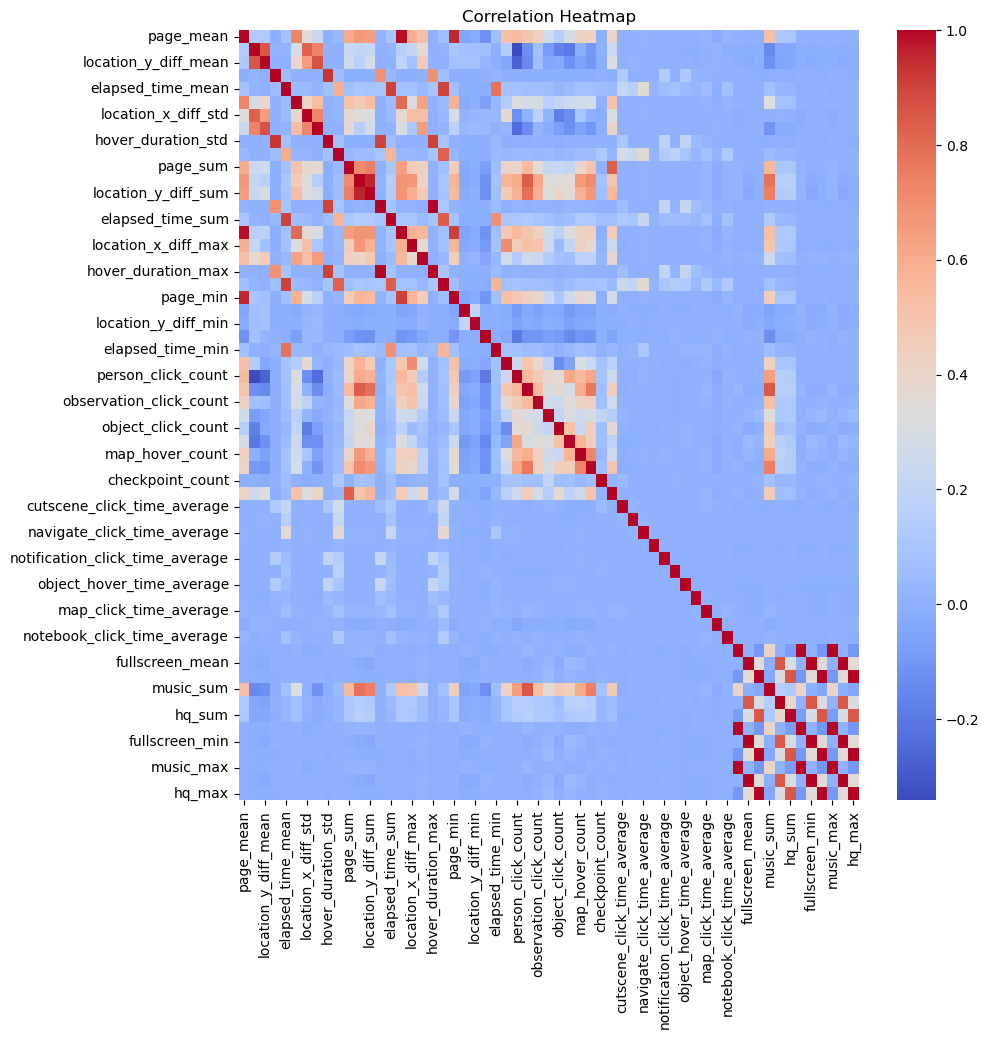

In [11]:
import seaborn as sns

correlation_matrix = dataset_df.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [12]:
num_rows, num_cols = dataset_df.shape

print("#row:", num_rows)
print("#col:", num_cols)

#row: 70686
#col: 60


In [13]:
# dataset_df = dataset_df.drop([
#     'navigate_click_max', 'object_hover_max', 'notification_click_max'
# ], axis=1)

In [14]:
FEATURES = [c for c in dataset_df.columns if c != 'level_group']
ALL_USERS = dataset_df.index.unique()

gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}
evaluation_dict ={}

In [15]:
for i, (train_index, test_index) in enumerate(gkf.split(X=dataset_df, groups=dataset_df.index)):
    print('-'*25)
    print('    <<<  Fold ',i+1, ' >>>')
    print('-'*25)
    
    # default: 0.684 ~ 0.685
    xgb_params = {
        'objective' : 'binary:logistic',
        'eval_metric':'logloss',
        'learning_rate': 0.02,
        'max_depth': 5,
        'n_estimators': 1000,
        'early_stopping_rounds': 50,
        'tree_method':'hist',
        'subsample':0.8,
        'colsample_bytree': 0.4,
        'use_label_encoder' : False
    }

    xgb_params_1 = {
        'objective' : 'binary:logistic',
        'eval_metric':'logloss',
        'learning_rate': 0.01,
        'max_depth': 5,
        'n_estimators': 1000,
        'early_stopping_rounds': 50,
        'tree_method':'hist',
        'subsample':0.5,
        'colsample_bytree': 1,
        'use_label_encoder' : False,
        
        ### Parameters Tuning.. 
        'gamma': 5,
        'min_child_weight': 8,
        'colsample_bytree': 0.5
    }
    
    xgb_params_test = {
        'objective' : 'binary:logistic',
        'eval_metric':'logloss',
        'learning_rate': 0.1,
        'max_depth': 7,
        'n_estimators': 1000,
        'early_stopping_rounds': 50,
        'tree_method':'hist',
        'subsample':0.7,
        'colsample_bytree': 0.7,
        'use_label_encoder' : False,
                
        ### Parameters Tuning.. 
        'random_state': 2,
        'gamma': 5,
        'min_child_weight': 1,
        'colsample_bytree': 0.5
    }
    
    for q_no in range(1,19):

        # Select level group for the question based on the q_no.
        if q_no<=3: grp = '0-4'
        elif q_no<=13: grp = '5-12'
        elif q_no<=22: grp = '13-22'


        # TRAIN DATA
        train_x = dataset_df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = labels.loc[labels.q==q_no].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = dataset_df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = labels.loc[labels.q==q_no].set_index('session').loc[valid_users]

        # We will now create the Gradient Boosted Trees Model with default settings. 
        # By default the model is set to train for a classification task.
        xgb = XGBClassifier(**xgb_params_test)
        xgb.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                eval_set=[ (valid_x[FEATURES].astype('float32'), valid_y['correct']) ],
                verbose=0)
        print(f'{q_no}({xgb.best_ntree_limit}), ',end='')
        
        # SAVE MODEL, PREDICT VALID OOF
        models[f'{grp}_{q_no}'] = xgb
        oof.loc[valid_users, q_no-1] = xgb.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]  
    print()

-------------------------
    <<<  Fold  1  >>>
-------------------------
1(51), 2(70), 3(60), 4(81), 5(44), 6(56), 7(27), 8(40), 9(56), 10(46), 11(34), 12(51), 13(37), 14(48), 15(75), 16(31), 17(19), 18(238), 
-------------------------
    <<<  Fold  2  >>>
-------------------------
1(59), 2(73), 3(62), 4(88), 5(44), 6(73), 7(34), 8(17), 9(44), 10(36), 11(34), 12(90), 13(29), 14(79), 15(44), 16(35), 17(25), 18(71), 
-------------------------
    <<<  Fold  3  >>>
-------------------------
1(84), 2(61), 3(80), 4(49), 5(30), 6(58), 7(54), 8(22), 9(45), 10(32), 11(24), 12(28), 13(54), 14(47), 15(39), 16(38), 17(46), 18(57), 
-------------------------
    <<<  Fold  4  >>>
-------------------------
1(84), 2(66), 3(58), 4(105), 5(33), 6(81), 7(35), 8(23), 9(72), 10(80), 11(35), 12(40), 13(117), 14(54), 15(55), 16(33), 17(24), 18(78), 
-------------------------
    <<<  Fold  5  >>>
-------------------------
1(129), 2(146), 3(47), 4(71), 5(47), 6(62), 7(32), 8(46), 9(40), 10(29), 11(27), 12

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

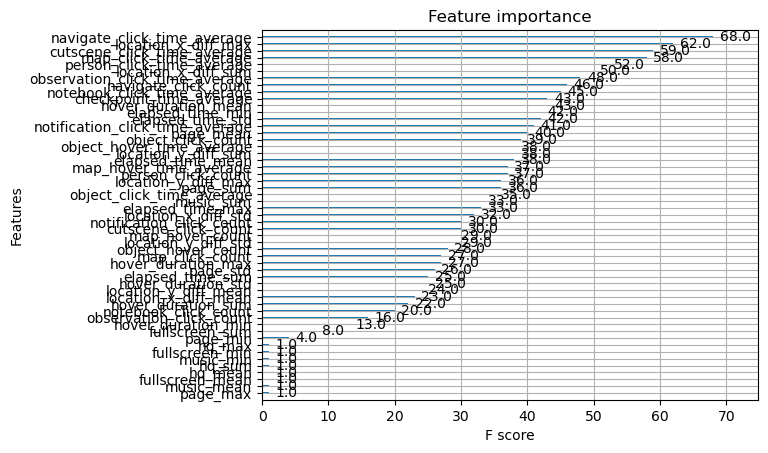

In [16]:
from xgboost import plot_importance

fig, ax = plt.subplots()
plot_importance(xgb, ax=ax)

In [17]:
true = oof.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = labels.loc[labels.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [18]:
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

In [19]:
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

Q0: F1 = 0.6548216287802632
Q1: F1 = 0.5097766046481684
Q2: F1 = 0.5055215639338019
Q3: F1 = 0.6386860294571926
Q4: F1 = 0.6087753457790049
Q5: F1 = 0.6048643309923845
Q6: F1 = 0.5921339653763129
Q7: F1 = 0.5548379021371761
Q8: F1 = 0.6021861888283291
Q9: F1 = 0.5613750403456516
Q10: F1 = 0.5950920101732057
Q11: F1 = 0.4991582491582492
Q12: F1 = 0.4634447156227267
Q13: F1 = 0.6068060349818313
Q14: F1 = 0.5629521094092169
Q15: F1 = 0.46979229777850257
Q16: F1 = 0.5396075861320837
Q17: F1 = 0.4912984255043998
==> Overall F1 = 0.682986454424978


In [20]:
# Reference
# https://www.kaggle.com/code/philculliton/basic-submission-demo
# https://www.kaggle.com/code/cdeotte/random-forest-baseline-0-664/notebook

import jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

for (test, sample_submission) in iter_test:
    # FEATURE ENGINEER TEST DATA
    df = feature_engineer(test)
    # INFER TEST DATA
    grp = test.level_group.values[0]
    a,b = limits[grp]
    for t in range(a,b):
        xgb = models[f'{grp}_{t}']
        p = xgb.predict_proba(df[FEATURES].astype('float32'))[0,1]
        mask = sample_submission.session_id.str.contains(f'q{t}')
        sample_submission.loc[mask,'correct'] = int( p > best_threshold )
    
    env.predict(sample_submission)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


In [21]:
# import jo_wilder
# env = jo_wilder.make_env()
# iter_test = env.iter_test()

# limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

# for (test, sample_submission) in iter_test:
#     # FEATURE ENGINEER TEST DATA
#     test_data = feature_engineer(test)
#     #test
#     test_session_id = test_data.index
#     test_session_df = pd.DataFrame(test_session_id)
#     test_session_df.name = 'session_id'
    
#     test_data_for_pca = test_data.drop(['level_group'], axis=1)
#     pca_test_result = pca.transform(test_data_for_pca)
#     pca_test_df = pd.DataFrame(pca_test_result)
    
#     test_data.reset_index(drop=True, inplace=True) 
#     test_data = pd.concat([test_session_df,test_data[['level_group']],pca_test_df], axis=1)
#     #test
#     # INFER TEST DATA
#     grp = test.level_group.values[0]
#     a,b = limits[grp]
#     for t in range(a,b):
#         xgb = models[f'{grp}_{t}']
#         p = xgb.predict_proba(test_data[FEATURES].astype('float32'))[0,1]
#         mask = sample_submission.session_id.str.contains(f'q{t}')
#         sample_submission.loc[mask,'correct'] = int( p > best_threshold )
    
#     env.predict(sample_submission)